In [ ]:
# Sources
# https://www.hackerearth.com/zh/problem/machine-learning/bank-fears-loanliness/
# https://github.com/HackerEarth-Challenges/machine-learning-challenge-1/blob/master/Bhupinder_Rank4_Python.ipynb

In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import re
import matplotlib.pyplot as plt
import xgboost
from sklearn import preprocessing, metrics
from sklearn import preprocessing
from sklearn.model_selection import KFold
import timeit
import random
from sklearn.metrics import accuracy_score
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from datetime import datetime

C:\Users\a1381\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


#### Finding separation of features. High separation means having better performance on classification

In [2]:
def calcWithinGroupsVariance(variable, groupvariable):
    # find out how many values the group variable can take
    levels = sorted(set(groupvariable))
    numlevels = len(levels)
    # get the mean and standard deviation for each group:
    numtotal = 0
    denomtotal = 0
    for leveli in levels:
        levelidata = variable[groupvariable==leveli]
        levelilength = len(levelidata)
        # get the standard deviation for group i:
        sdi = np.std(levelidata)
        numi = (levelilength)*sdi**2
        denomi = levelilength
        numtotal = numtotal + numi
        denomtotal = denomtotal + denomi
    # calculate the within-groups variance
    Vw = numtotal / (denomtotal - numlevels)
    return Vw

def calcBetweenGroupsVariance(variable, groupvariable):
    # find out how many values the group variable can take
    levels = sorted(set((groupvariable)))
    numlevels = len(levels)
    # calculate the overall grand mean:
    grandmean = np.mean(variable)
    # get the mean and standard deviation for each group:
    numtotal = 0
    denomtotal = 0
    for leveli in levels:
        levelidata = variable[groupvariable==leveli]
        levelilength = len(levelidata)
        # get the mean and standard deviation for group i:
        meani = np.mean(levelidata)
        sdi = np.std(levelidata)
        numi = levelilength * ((meani - grandmean)**2)
        denomi = levelilength
        numtotal = numtotal + numi
        denomtotal = denomtotal + denomi
    # calculate the between-groups variance
    Vb = numtotal / (numlevels - 1)
    return(Vb)

def calcSeparations(variables, groupvariable):
    # calculate the separation for each variable
    for variablename in variables:
        variablei = variables[variablename]
        Vw = calcWithinGroupsVariance(variablei, groupvariable)
        Vb = calcBetweenGroupsVariance(variablei, groupvariable)
        sep = Vb/Vw
        print(variablename, "\nseparation=", sep, '\n')

#### Read the data and combine the training and testing data

In [3]:
tr = pd.read_csv('train.csv')
te = pd.read_csv('test.csv')
print('shape of train data:', tr.shape)
print('shae of test data:', te.shape)

shape of train data: (532428, 45)
shae of test data: (354951, 44)


#### Copy the target and id for training and prediction

In [4]:
# train = tr.copy()
test_member_id = pd.DataFrame(te['member_id'])
train_member_id = pd.DataFrame(tr['member_id'])
train_target = pd.DataFrame(tr['loan_status'])

In [5]:
# Combine training and testing data
del tr['loan_status']
alldata = tr.append(te)

#### Record the number of missing information in each transaction

In [6]:
n = alldata.isnull().sum(axis=1)
alldata['nulls'] = n

#### Select the columns we need

In [7]:
alldata = alldata[['member_id', 'loan_amnt', 'sub_grade', 'initial_list_status', 'title', 'desc',\
                 'term', 'emp_length', 'int_rate', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths',\
                 'open_acc', 'pub_rec', 'revol_bal', 'nulls',\
                 'revol_util', 'total_acc', 'total_rec_int', 'total_rec_late_fee', 'recoveries',\
                 'collection_recovery_fee', 'collections_12_mths_ex_med',\
                 'last_week_pay', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim']]

In [8]:
# Copy the data
falldata = alldata.copy()

#### Convert features(emp_length, last_week_pay, sub_grade, term) into numerical feature and use median to fill NA

In [9]:
def clean_emp_length(raw):
    try:
        if '<' in raw:
            return 1
        elif 'n/a' in raw:
            return np.nan
        elif '+' in raw:
            return 10
        else:
            return int(re.sub("\D", "", raw)) # \D match any non-digit character
    except:
        return np.nan

falldata['emp_length'] = falldata.emp_length.apply(clean_emp_length)
falldata['emp_length'] = falldata.emp_length.fillna(falldata.emp_length.median())

In [10]:
def clean_last_week_pay(raw):
    try:
        return int(re.sub('\D', '', raw))
    except:
        return np.nan #-9999

falldata['last_week_pay'] = falldata.last_week_pay.apply(clean_last_week_pay)
falldata['last_week_pay'] = falldata.last_week_pay.fillna(falldata.last_week_pay.median())

In [11]:
def clean_sub_grade(raw):
    try:
        if 'A' in raw:
            return int(raw.replace('A', '0'))
        if 'B' in raw:
            return int(raw.replace('B', '1'))
        if 'C' in raw:
            return int(raw.replace('C', '2'))
        if 'D' in raw:
            return int(raw.replace('D', '3'))
        if 'E' in raw:
            return int(raw.replace('E', '4'))
        if 'F' in raw:
            return int(raw.replace('F', '5'))
        if 'G' in raw:
            return int(raw.replace('G', '6'))
    except:
        return np.nan
    
falldata['sub_grade'] = falldata.sub_grade.apply(clean_sub_grade)

In [12]:
def clean_term(raw):
    try:
        return int(re.sub('\D', '', raw))
    except:
        return 0
    
falldata['term'] = falldata.term.apply(clean_term)

#### Try to know how many NAs in each feature

In [13]:
falldata.isnull().apply(Counter, 0)

member_id                                   {False: 887379}
loan_amnt                                   {False: 887379}
sub_grade                                   {False: 887379}
initial_list_status                         {False: 887379}
title                            {False: 887228, True: 151}
desc                          {True: 761598, False: 125781}
term                                        {False: 887379}
emp_length                                  {False: 887379}
int_rate                                    {False: 887379}
annual_inc                         {False: 887375, True: 4}
dti                                         {False: 887379}
delinq_2yrs                       {False: 887350, True: 29}
inq_last_6mths                    {False: 887350, True: 29}
open_acc                          {False: 887350, True: 29}
pub_rec                           {False: 887350, True: 29}
revol_bal                                   {False: 887379}
nulls                                   

#### From above chart, we can see that there are something weird. Features(delinq_2yrs, inq_last_6mths, open_acc, pub_rec, total_acc, acc_now_delinq) all have the same number of NA and after printing out, all NAs happen in the same transactions. There must be something wrong when recording data.
#### However, I just ignore them and fill them with median

In [14]:
falldata[['delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'total_acc', 'acc_now_delinq']].loc[pd.isnull(falldata.delinq_2yrs)]

,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,total_acc,acc_now_delinq
152427,NaN,NaN,NaN,NaN,NaN,NaN
158498,NaN,NaN,NaN,NaN,NaN,NaN
170053,NaN,NaN,NaN,NaN,NaN,NaN
198875,NaN,NaN,NaN,NaN,NaN,NaN
206905,NaN,NaN,NaN,NaN,NaN,NaN
212464,NaN,NaN,NaN,NaN,NaN,NaN
283835,NaN,NaN,NaN,NaN,NaN,NaN
325674,NaN,NaN,NaN,NaN,NaN,NaN
337233,NaN,NaN,NaN,NaN,NaN,NaN
392373,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
falldata[['delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'total_acc', 'acc_now_delinq']] = \
falldata[['delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'total_acc', 'acc_now_delinq']].\
fillna(falldata[['delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'total_acc', 'acc_now_delinq']].median())

#### Same for features(tot_coll_amt, tot_cur_bal , total_rev_hi_lim ). Also, the number of these three are almost the same so I decide to remove two of them

In [16]:
del falldata['tot_coll_amt']
del falldata['tot_cur_bal']

In [17]:
# Fill NAs with median
falldata.annual_inc = falldata.annual_inc.fillna(falldata.annual_inc.median())
falldata.revol_util = falldata.revol_util.fillna(falldata.revol_util.median())
falldata.collections_12_mths_ex_med = falldata.collections_12_mths_ex_med.fillna(falldata.collections_12_mths_ex_med.median())
falldata.total_rev_hi_lim = falldata.total_rev_hi_lim.fillna(falldata.total_rev_hi_lim.median())

#### Features(title and desc) are tricky. They have tens of thousands of cardinalities. For here, I fill the NAs with new level(unknown) first and then transform them with label encoder without any preprocesing. Finally calculate them with function calcSeparation to whether to keep them or not

In [18]:
falldata.title = falldata.title.fillna('unknown')
falldata.desc = falldata.desc.fillna('unknown')

In [19]:
falldata.title = falldata.title.astype('category').cat.codes
falldata.desc = falldata.desc.astype('category').cat.codes
falldata.initial_list_status = falldata.initial_list_status.astype('category').cat.codes

#### The saparations are very high, so I decide to keep them

In [20]:
X = falldata.loc[:, ['title', 'desc']][:532428]
y = train_target.loan_status

calcSeparations(X, y)

title 
separation= 17909.287352066418 

desc 
separation= 52200.4475120457 



#### Now we have the data without any miising values

In [21]:
falldata.isnull().apply(Counter, 0)

member_id                     {False: 887379}
loan_amnt                     {False: 887379}
sub_grade                     {False: 887379}
initial_list_status           {False: 887379}
title                         {False: 887379}
desc                          {False: 887379}
term                          {False: 887379}
emp_length                    {False: 887379}
int_rate                      {False: 887379}
annual_inc                    {False: 887379}
dti                           {False: 887379}
delinq_2yrs                   {False: 887379}
inq_last_6mths                {False: 887379}
open_acc                      {False: 887379}
pub_rec                       {False: 887379}
revol_bal                     {False: 887379}
nulls                         {False: 887379}
revol_util                    {False: 887379}
total_acc                     {False: 887379}
total_rec_int                 {False: 887379}
total_rec_late_fee            {False: 887379}
recoveries                    {Fal

In [22]:
# def helping_features(value):
#     falldata['Interest'] = falldata['loan_amnt']*falldata['int_rate']*falldata['term']/(100*12)
#     if value == -9999:
#         # monthly income * dti = monthly repayment
#         falldata['Monthly_income'] = falldata['annual_inc'].apply(lambda x : x/12 if x >=0 else -9999)
#         falldata['Monthly_debt_repay'] = falldata['Monthly_income'] * falldata['dti']/100
#         falldata['Monthly_debt_repay'] = falldata['Monthly_debt_repay'].apply(lambda x : x if x>0 else -9999)
        
#     else :
#         falldata['Monthly_income'] = falldata['annual_inc']/12
#         falldata['Monthly_debt_repay'] = falldata['Monthly_income'] * falldata['dti']/100

# helping_features(-9999)

In [23]:
# Total interest
falldata['Interest'] = falldata['loan_amnt']*falldata['int_rate']*falldata['term']/(100*12)

# Remaing interest (%)
falldata['unpaid_perc'] = (falldata['Interest'] - falldata['total_rec_int'])/falldata['Interest']

# Monthly debt repayment
falldata['Monthly_income'] = falldata['annual_inc'].apply(lambda x : x/12 if x >=0 else -9999)
falldata['Monthly_debt_repay'] = falldata['Monthly_income'] * falldata['dti']/100
falldata['Monthly_debt_repay'] = falldata['Monthly_debt_repay'].apply(lambda x : x if x>0 else -9999)

# How big the loan a person has taken with respect to his earnings, annual income to loan amount ratio
falldata['loan_to_income'] = falldata['annual_inc']/falldata['loan_amnt']

# All these attributes indicate that the repayment was not all hunky-dory. All the amounts caclulated are ratios 
# like, recovery to the loan amount. This column gives a magnitude of how much the repayment has gone off course 
# in terms of ratios.
falldata['bad_state'] = falldata['acc_now_delinq'] + (falldata['total_rec_late_fee']/falldata['loan_amnt']) + (falldata['recoveries']/falldata['loan_amnt']) + (falldata['collection_recovery_fee']/falldata['loan_amnt']) + (falldata['collections_12_mths_ex_med']/falldata['loan_amnt'])

# For the sake of this model, I have used just a boolean flag if things had gone bad, with this case I didn't see
# a benifit of including above computations
falldata.loc[falldata['bad_state'] > 0, 'bad_state'] = 1

# Total number of available/unused 'credit lines'
falldata['avl_lines'] = falldata['total_acc'] - falldata['open_acc']

# Interest paid so far
falldata['int_paid'] = falldata['total_rec_int'] + falldata['total_rec_late_fee']

# Calculating EMIs paid (in terms of percent)
falldata['emi_paid_progress_perc'] = ((falldata['last_week_pay']/(falldata['term']/12*52+1))*100)

# Calculating total repayments received so far, in terms of EMI or recoveries after charge off
falldata['total_repayment_progress'] = ((falldata['last_week_pay']/(falldata['term']/12*52+1))*100) + ((falldata['recoveries']/falldata['loan_amnt']) * 100)


falldata['iti'] = falldata['Interest']/falldata['Monthly_income']/12
falldata['dti_and_iti'] = falldata['iti'] + falldata['dti']
falldata['dtc'] = falldata['Monthly_debt_repay']/falldata['total_rev_hi_lim']/12
falldata['itc'] = falldata['Interest']/falldata['total_rev_hi_lim']/(12*12)
falldata['last_to_term'] = falldata['last_week_pay']/(falldata['term']*52/12)

In [25]:
# make a copy
ff = falldata.copy()

#### After many attempts, I remove features with few contribution

In [27]:
del ff['int_paid']
del ff['bad_state']
del ff['Monthly_income']
del ff['collection_recovery_fee']
del ff['collections_12_mths_ex_med']
del ff['acc_now_delinq']
del ff['delinq_2yrs']
del ff['pub_rec']

#### Prepare data for training

In [28]:
train_new = ff[:532428]
test_new = ff[532428:]

In [29]:
# Using stratified sampling to separate data into training data and validation data
X_train, X_test, y_train, y_test = train_test_split(np.array(train_new),\
                                                    np.array(train_target),\
                                                    stratify=np.array(train_target),\
                                                    test_size=0.25)
eval_set=[(X_test, y_test)]

In [30]:
# http://xgboost.readthedocs.io/en/latest/python/python_api.html    Parameter tuning
# https://www.2cto.com/kf/201607/528771.html
st = datetime.now()

clf = xgboost.sklearn.XGBClassifier(
    objective="binary:logistic", 
    learning_rate=0.05, 
    seed=9616, 
    max_depth=17, 
    gamma=0.5, 
    n_estimators=500,
    reg_alpha=0.1)

clf.fit(X_train, y_train, early_stopping_rounds=20, eval_metric="auc", eval_set=eval_set, verbose=True)

C:\Users\a1381\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:112: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\a1381\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[0]	validation_0-auc:0.971152
Will train until validation_0-auc hasn't improved in 20 rounds.
[1]	validation_0-auc:0.972391
[2]	validation_0-auc:0.973659
[3]	validation_0-auc:0.974564
[4]	validation_0-auc:0.975
[5]	validation_0-auc:0.975353
[6]	validation_0-auc:0.975634
[7]	validation_0-auc:0.976099
[8]	validation_0-auc:0.976429
[9]	validation_0-auc:0.976625
[10]	validation_0-auc:0.977091
[11]	validation_0-auc:0.977243
[12]	validation_0-auc:0.977586
[13]	validation_0-auc:0.977836
[14]	validation_0-auc:0.97812
[15]	validation_0-auc:0.978303
[16]	validation_0-auc:0.978417
[17]	validation_0-auc:0.978598
[18]	validation_0-auc:0.978726
[19]	validation_0-auc:0.978941
[20]	validation_0-auc:0.979099
[21]	validation_0-auc:0.97936
[22]	validation_0-auc:0.979481
[23]	validation_0-auc:0.979578
[24]	validation_0-auc:0.979654
[25]	validation_0-auc:0.979759
[26]	validation_0-auc:0.979868
[27]	validation_0-auc:0.980063
[28]	validation_0-auc:0.980155
[29]	validation_0-auc:0.98024
[30]	validation_0-auc:

[259]	validation_0-auc:0.983917
[260]	validation_0-auc:0.983921
[261]	validation_0-auc:0.983922
[262]	validation_0-auc:0.98392
[263]	validation_0-auc:0.98392
[264]	validation_0-auc:0.983932
[265]	validation_0-auc:0.983936
[266]	validation_0-auc:0.983935
[267]	validation_0-auc:0.983936
[268]	validation_0-auc:0.983942
[269]	validation_0-auc:0.983954
[270]	validation_0-auc:0.983978
[271]	validation_0-auc:0.983976
[272]	validation_0-auc:0.983982
[273]	validation_0-auc:0.983971
[274]	validation_0-auc:0.983971
[275]	validation_0-auc:0.983972
[276]	validation_0-auc:0.983973
[277]	validation_0-auc:0.983981
[278]	validation_0-auc:0.983986
[279]	validation_0-auc:0.983986
[280]	validation_0-auc:0.983989
[281]	validation_0-auc:0.983988
[282]	validation_0-auc:0.983991
[283]	validation_0-auc:0.983992
[284]	validation_0-auc:0.983996
[285]	validation_0-auc:0.984
[286]	validation_0-auc:0.984021
[287]	validation_0-auc:0.984024
[288]	validation_0-auc:0.984023
[289]	validation_0-auc:0.984021
[290]	validat

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0.5, learning_rate=0.05, max_delta_step=0, max_depth=17,
       min_child_weight=1, missing=None, n_estimators=500, nthread=-1,
       objective='binary:logistic', reg_alpha=0.1, reg_lambda=1,
       scale_pos_weight=1, seed=9616, silent=True, subsample=1)

0:21:10.684489
Accuracy: 95.4900944353%
ROC-AUC: 94.0540999440%
[  9.17947367e-02   2.65576877e-02   2.96088178e-02   5.28615573e-03
   3.04601714e-02   1.43249705e-02   1.85077137e-03   2.32562646e-02
   2.45465171e-02   3.79126109e-02   3.87146138e-02   1.24089820e-02
   2.62668524e-02   4.25254405e-02   1.30065167e-02   5.40813021e-02
   2.88191549e-02   3.52633633e-02   4.15630359e-03   9.48300003e-04
   3.02574690e-02   3.20747495e-02   2.15905700e-02   3.89931090e-02
   1.21452905e-01   3.94249558e-02   3.11775673e-02   7.91601371e-03
   2.89954199e-03   3.72780599e-02   1.49295563e-02   4.18538749e-02
   3.83180194e-02   4.40659860e-05]
0 member_id
1 loan_amnt
2 sub_grade
3 initial_list_status
4 title
5 desc
6 term
7 emp_length
8 int_rate
9 annual_inc
10 dti
11 inq_last_6mths
12 open_acc
13 revol_bal
14 nulls
15 revol_util
16 total_acc
17 total_rec_int
18 total_rec_late_fee
19 recoveries
20 last_week_pay
21 total_rev_hi_lim
22 Interest
23 Monthly_debt_repay
24 unpaid_perc
25 loa

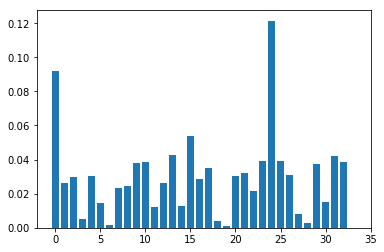

In [31]:
print(datetime.now()-st)
y_pred = clf.predict(X_test)
submission_file_name = 'Submission_'

accuracy = accuracy_score(np.array(y_test).flatten(), y_pred)
print("Accuracy: %.10f%%" % (accuracy * 100.0))
submission_file_name = submission_file_name + ("_Accuracy_%.6f" % (accuracy * 100)) + '_'

accuracy_per_roc_auc = roc_auc_score(np.array(y_test).flatten(), y_pred)
print("ROC-AUC: %.10f%%" % (accuracy_per_roc_auc * 100))
submission_file_name = submission_file_name + ("_ROC-AUC_%.6f" % (accuracy_per_roc_auc * 100))

print(clf.feature_importances_)
idx = 0
for x in list(train_new):
    print('%d %s' % (idx, x))
    idx = idx + 1
plt.bar(range(len(clf.feature_importances_)), clf.feature_importances_)
plt.show()

#### Final score on website hackerearth - Bank Fears Loanliness is 0.98442

In [ ]:
# Submission
final_pred = pd.DataFrame(clf.predict_proba(np.array(test_new)))
dfSub = pd.concat([test_member_id, final_pred.ix[:, 1:2]], axis=1)
dfSub.rename(columns={1:'loan_status'}, inplace=True)
dfSub.to_csv((('%s.csv') % (submission_file_name)), index=False)

# ---------------------------------------------------------------------------------------------------------

In [ ]:
# grouped = train.groupby(['addr_state', 'loan_status']).size()
# grouped_shift = grouped.shift()
# grouped_1 = grouped[1::2]
# grouped_sum = grouped + grouped_shift
# gtouped_sum = grouped_sum[1::2]
# grouped_ratio = grouped_1 / gtouped_sum # Defaulter / total

In [ ]:
# fig, ax = plt.subplots()
# ax.plot(grouped_ratio.values)
# ax.set(title='Defaulter / total', xlabel='State', ylabel='Ratio')
# plt.show()

In [ ]:
# grouped_ratio.loc[(grouped_ratio > 0.6) | (grouped_ratio < 0.2)]

In [ ]:
# tt = train[['addr_state', 'loan_status']].loc[(train.addr_state == 'IA') | (train.addr_state == 'IN') | (train.addr_state == 'ME') | (train.addr_state == 'MS') | (train.addr_state == 'ND') | (train.addr_state == 'NE') | (train.addr_state == 'TN')]
# tt.groupby(by='addr_state').size()

# ---------------------------------------------------------------------------------------------------------

In [ ]:
# c = Counter()
# for raw in falldata.title:
#     c.update(raw.lower().split())
# c.most_common()

# ---------------------------------------------------------------------------------------------------------

In [ ]:
# def clean_title(raw):
#     raw = raw.lower()
#     if ('debt' in raw) or ('consol' in raw) or ('lidation' in raw) or ('together' in raw):
#         return 'consolidation'
#     elif ('credit' in raw) or ('card' in raw) or ('debit' in raw):
#         return 'card'
#     elif ('wedd' in raw) or ('marr' in raw):
#         return 'wedding'
#     elif ('home' in raw) or ('house' in raw) or ('place' in raw) or ('landscaping' in raw) or ('bath' in raw) or ('furni' in raw) or ('tub' in raw) or ('room' in raw) or ('basement' in raw) or ('kitchen' in raw):
#         return 'home'
#     elif ('car' in raw) or ('moto' in raw) or ('truck' in raw) or ('auto' in raw) or ('jeep' in raw) or ('boat' in raw) or ('honda' in raw) or ('volvo' in raw):
#         return 'vehicle'
#     elif ('pay' in raw) or ('off' in raw):
#         return 'payoff'
#     elif ('free' in raw) or ('out' in raw):
#         return 'freedom'
#     elif 'pool' in raw:
#         return 'pool'
#     elif 'persona' in raw :
#         return 'personal'
#     elif 'vacation' in raw:
#         return 'vacation'
#     elif ('hosp' in raw) or ('med' in raw) or ('dental' in raw):
#         return 'medical'
#     elif 'loan' in raw:
#         return 'some loan'
#     elif ('mov' in raw) or ('reloc' in raw):
#         return 'moving'
#     elif 'refi' in raw:
#         return 'refinance'
#     elif ('new' in raw) or ('special' in raw) or ('start' in raw) or ('fresh' in raw) or ('happy' in raw):
#         return 'happiness'
#     elif 'purch' in raw:
#         return 'bigamount'
#     elif 'business' in raw:
#         return 'business'
#     elif ('vacation' in raw) or ('summer' in raw) or ('christmas' in raw):
#         return 'vacation'
#     elif ('cc' in raw) or ('c c' in raw):
#         return 'cc'
#     elif 'bill' in raw:
#         return 'bills'
#     elif 'help' in raw:
#         return 'help'
#     elif 'small' in raw:
#         return 'small'
#     elif 'edu' in raw:
#         return 'education'
#     elif 'cash' in raw:
#         return 'cash'
#     elif 'first' in raw:
#         return 'first'
#     elif 'relief' in raw:
#         return 'relief'
#     else :
#         return raw
    


In [ ]:
# fill the missing values with unknown, maybe it is intentionally left blank
# falldata[['title']] = falldata[['title']].fillna(value='unknown')
# falldata['title'] = falldata.title.apply(clean_title)

In [ ]:
# falldata['title'] = falldata['title'].astype('category')
# falldata['title'] = falldata['title'].cat.codes

In [ ]:
# title_list = falldata.title.values

# from collections import Counter
# wordsDict = Counter(title_list)
# wordsDictSorted = wordsDict.most_common()
# wordsDictSorted = dict(wordsDictSorted)

# title_list = []
# for i in wordsDictSorted:
#     if wordsDictSorted[i] > 10:
#         title_list.append(i)
#     else :
#         break

In [ ]:
# def final_title(raw):
#     if raw in title_list:
#         return raw
#     else :
#         return 'Other 2'
# falldata['title'] = falldata.title.apply(final_title)